# Fashion Dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import time

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape for PCA (flatten images)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)



In [ ]:
# Baseline model (no PCA)
def create_model(input_shape=784):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train baseline model
baseline_model = create_model()
baseline_start = time.time()
baseline_history = baseline_model.fit(x_train_flat, y_train, epochs=10, validation_data=(x_test_flat, y_test), verbose=0)
baseline_end = time.time()
baseline_time = baseline_end - baseline_start

# Apply PCA and find best n_components
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Explained variance to find best n_components
pca = PCA().fit(x_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # 95% variance
print(f"Optimal n_components: {n_components}")

# Apply PCA with optimal components
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Train model with PCA
pca_model = create_model(input_shape=n_components)
pca_start = time.time()
pca_history = pca_model.fit(x_train_pca, y_train, epochs=10, validation_data=(x_test_pca, y_test), verbose=0)
pca_end = time.time()
pca_time = pca_end - pca_start

# Compare performance
baseline_accuracy = baseline_model.evaluate(x_test_flat, y_test, verbose=0)[1]
pca_accuracy = pca_model.evaluate(x_test_pca, y_test, verbose=0)[1]

print(f"Baseline Accuracy: {baseline_accuracy:.4f}, Training Time: {baseline_time:.2f} seconds")
print(f"PCA Accuracy: {pca_accuracy:.4f}, Training Time: {pca_time:.2f} seconds")


Optimal n_components: 256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline Accuracy: 0.8836, Training Time: 61.02 seconds
PCA Accuracy: 0.8870, Training Time: 66.79 seconds


# Iris dataset

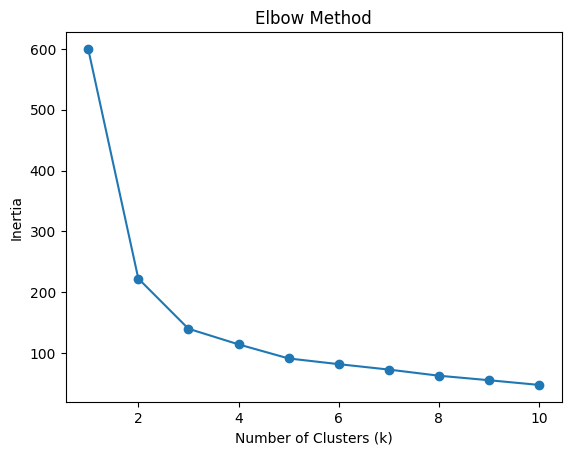

Cluster Centers:
 [[5.80188679 2.67358491 4.36981132 1.41320755]
 [5.006      3.428      1.462      0.246     ]
 [6.78085106 3.09574468 5.5106383  1.97234043]]


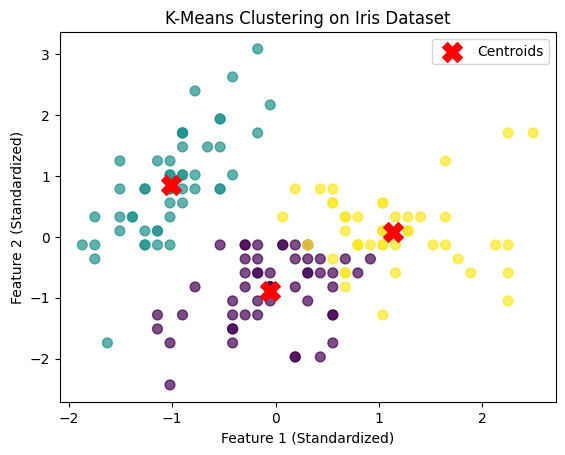

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find optimal k
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with optimal k (let's say 3 from the elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Add cluster labels to the original data
df = pd.DataFrame(X, columns=iris.feature_names)
df['Cluster'] = labels
df['Actual'] = y

# Display the cluster assignments and centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:\n", centroids)

# Visualization (using first two features for simplicity)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering on Iris Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()


# M1 dataset

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFE, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
# Load the DataFrames first
df_train = pd.read_csv("steam_train.csv")
df_test = pd.read_csv("steam_test.csv")



In [ ]:
# Handle missing values
df_train.fillna(df_train.median(numeric_only=True), inplace=True)
df_test.fillna(df_test.median(numeric_only=True), inplace=True)

# Verify if 'output_electricity_generation' column exists
if 'output_electricity_generation' not in df_train.columns:
    df_train['output_electricity_generation'] = 0  # or any default value
if 'output_electricity_generation' not in df_test.columns:
    df_test['output_electricity_generation'] = 0  # or any default value

# Encode 'day' into numerical format if it exists
label_encoder = LabelEncoder()
if 'day' in df_train.columns:
    df_train['day_encoded'] = label_encoder.fit_transform(df_train['day'].astype(str))
    df_test['day_encoded'] = label_encoder.transform(df_test['day'].astype(str))

# Time features
df_train['time_in_minutes'] = df_train['hour'] * 60 + df_train['minute']
df_test['time_in_minutes'] = df_test['hour'] * 60 + df_test['minute']
df_train['part_of_day'] = pd.cut(df_train['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
df_test['part_of_day'] = pd.cut(df_test['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
df_train['part_of_day_encoded'] = label_encoder.fit_transform(df_train['part_of_day'].astype(str))
df_test['part_of_day_encoded'] = label_encoder.transform(df_test['part_of_day'].astype(str))

# Interaction features
df_train['feed_vapour_interaction'] = df_train['feed_water_motion'] * df_train['vapour_motion']
df_test['feed_vapour_interaction'] = df_test['feed_water_motion'] * df_test['vapour_motion']
df_train['pressure_efficiency'] = df_train['vapour_pressure'] / (df_train['vapour_temperature'] + 1e-5)
df_test['pressure_efficiency'] = df_test['vapour_pressure'] / (df_test['vapour_temperature'] + 1e-5)

# Lag features
df_train['prev_output'] = df_train['output_electricity_generation'].shift(1).fillna(0)
df_test['prev_output'] = df_test['output_electricity_generation'].shift(1).fillna(0)

# Drop non-numeric columns
if 'uid' in df_train.columns:
    df_train = df_train.drop(['uid'], axis=1)
if 'uid' in df_test.columns:
    df_test = df_test.drop(['uid'], axis=1)
df_train = df_train.drop(['part_of_day'], axis=1)
df_test = df_test.drop(['part_of_day'], axis=1)
if 'day' in df_train.columns:
    df_train = df_train.drop(['day'], axis=1)
    df_test = df_test.drop(['day'], axis=1)

# Split features and target
X_train = df_train.drop('output_electricity_generation', axis=1)
y_train = df_train['output_electricity_generation']
X_test = df_test.drop('output_electricity_generation', axis=1)
y_test = df_test['output_electricity_generation']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Correlation Analysis
correlations = df_train.corr()['output_electricity_generation'].sort_values(ascending=False)
print("Feature Correlations:\n", correlations)

# Feature Selection: Mutual Information
mi = mutual_info_regression(X_train_scaled, y_train)
mi_features = np.argsort(mi)[-10:]  # Top 10 features
X_train_mi = X_train.iloc[:, mi_features]
X_test_mi = X_test.iloc[:, mi_features]

# Feature Selection: Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

# Train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'{model.__class__.__name__} - RMSE: {rmse:.4f}, R²: {r2:.4f}')

# Test different models
models = [LinearRegression(), RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42)]
for model in models:
    print(f"\nEvaluating {model.__class__.__name__} with Mutual Information Features:")
    train_and_evaluate(model, X_train_mi, y_train, X_test_mi, y_test)

    print(f"\nEvaluating {model.__class__.__name__} with RFE Features:")
    train_and_evaluate(model, X_train_rfe, y_train, X_test_rfe, y_test)


Feature Correlations:
 output_electricity_generation    1.000000
feed_water_motion                0.934091
feed_vapour_interaction          0.880114
vapour_temperature               0.756113
vapour_motion                    0.747171
vapour_pressure_at_division      0.744575
vapour_pressure                  0.739847
C_motion                         0.737023
pressure_efficiency              0.669327
part_of_day_encoded              0.419569
feed_water_enth                  0.416756
prev_output                     -0.004036
minute                          -0.017016
faucet_hole                     -0.116018
hour                            -0.330818
time_in_minutes                 -0.331152
day_encoded                     -0.365933
vapour_enthalpy                 -0.674924
Name: output_electricity_generation, dtype: float64

Evaluating LinearRegression with Mutual Information Features:
LinearRegression - RMSE: 849.8711, R²: 0.0000

Evaluating LinearRegression with RFE Features:
LinearRegres

In [ ]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

RMSE: 851.6524
R²: 0.0000
